Imports:

In [162]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
!pip install pymc
import pymc as pm
import numpy as np

**Sanity check:**

Building the dataset:

In [ ]:
X = np.random.randn(100, 2)
Y = np.tanh(X[:, 0] + X[:, 1])
Y = 1./ (1. + np.exp(-(Y + Y)))
Y = np.array([int(x) for x in Y > 0.5])                                                               #labels

Building the network:

In [ ]:
n_nodes = 6
w = pm.Container([pm.Normal("w_%i"%j, 0, 1, value=np.random.randn(100)) for j in range(n_nodes)])

In [ ]:
@pm.deterministic
def NN(X=X, w=w):
  node1 = np.tanh(w[0]*X[:, 0] + w[1]*X[:, 1])
  node2 = np.tanh(w[2]*X[:, 0] + w[3]*X[:, 1])
  node3 = 1. / (1 + np.exp(-(w[4] * node1 + w[5] * node2)))
  return node3

Building the model:

In [ ]:
n_iter = 30000
burn = 0

y = pm.Container("labels_train", Y)

predictions = pm.Bernoulli("predictions", NN, value=np.random.randn(100), observed=y)

model = pm.Model([predictions, w, y, NN])
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(iter=n_iter, burn=burn)

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 30000 of 30000 complete in 16.4 sec

Testing the accuracy:

In [ ]:
def NN2(X=X, w=w):
  node1 = np.tanh(w[0]*X[:, 0] + w[1]*X[:, 1])
  node2 = np.tanh(w[:][2]*X[:, 0] + w[:][3]*X[:, 1])
  node3 = 1. / (1 + np.exp(-(w[4] * node1 + w[5] * node2)))
  return node3

In [ ]:
#Tracing the weights
new_w = []
for i in range(n_nodes):
  new_w.append(mcmc.trace("w_%i"%i)[n_iter-1-burn])

#Calculating the probabilities for the Bernoulli training labels:
train_pred_p = NN2(X, new_w)

#Obtaining the labels with Bernoulli:
train_pred = []
for i in range(len(train_pred_p)):
  train_pred.append(np.random.binomial(1, train_pred_p[i])) 


print("Accuracy of the sanity check model: {}%".format(sum(train_pred2 == Y)))

Accuracy of the sanity check model: 52%


**My binary example:**

Building the dataset:

In [165]:
data_size = 100
x1_0, x2_0 = make_regression(n_samples = data_size, n_features=1, bias = 0.0, noise=12.3)                     #label 0
x1_1, x2_1 = make_regression(n_samples = data_size, n_features=1, bias = 5.0, noise=12.3)                     #label 1

x1_1 = 2*x1_1 + 7                                                                                   #changing the center position of the cluster of points
x2_1 = 2*x2_1 + 7

X_0 = np.concatenate((x1_0, x2_0.reshape(-1, 1)), axis=1)                                                     #shape = (100, 2)
X_1 = np.concatenate((x1_1, x2_1.reshape(-1, 1)), axis=1)                                                     #shape = (100, 2)


slice1 = int(data_size/2)

X_train = np.concatenate((X_0[:slice1][:], X_1[:slice1][:]), axis = 0)                                                           #shape = (100, 2)
labels_train = np.concatenate((np.array([0. for i in range(slice1)]), np.array([1. for i in range(slice1)])), axis = None)
X_test = np.concatenate((X_0[slice1:][:], X_1[slice1:][:]), axis = 0)                                                            #shape = (100, 2)
labels_test = np.concatenate((np.array([0. for i in range(slice1)]), np.array([1. for i in range(slice1)])), axis = None)


train = list(zip(X_train, labels_train))                                                       #shuffling data
test = list(zip(X_test, labels_test))

#Shuffling data
np.random.shuffle(train)
np.random.shuffle(test)

for i in range(data_size):
  X_train[i] = train[i][0]
  X_test[i] = test[i][0]
  labels_train[i] = train[i][1]
  labels_test[i] = test[i][1]

Plotting generated data:

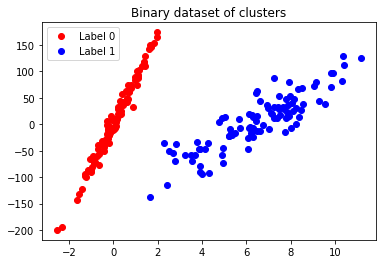

In [166]:
plt.plot(x1_0, x2_0, 'ro')
plt.plot(x1_1, x2_1, 'bo')
plt.legend(["Label 0", "Label 1"])
plt.title("Binary dataset of clusters")
plt.show()

Building the network:

In [167]:
n_nodes = 6
w = pm.Container([pm.Normal("w_%i"%j, 0, 1, value=np.random.randn(data_size)) for j in range(n_nodes)])

In [168]:
@pm.deterministic
def NN2(X=X_train, w=w):
  node1 = np.tanh(w[0]*X[:, 0] + w[1]*X[:, 1])
  node2 = np.tanh(w[:][2]*X[:, 0] + w[:][3]*X[:, 1])
  node3 = 1. / (1 + np.exp(-(w[4] * node1 + w[5] * node2)))
  return node3

Building the model:

In [169]:
n_iter = 1000
burn = 0

y = pm.Container("labels_train1", labels_train)

predictions = pm.Bernoulli("predictions", NN2, value=np.random.randn(data_size), observed=y)

model = pm.Model([predictions, w, y, NN2])
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(iter=n_iter, burn=burn)

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 1000 of 1000 complete in 0.6 sec

Tracing the predictions:

In [ ]:
def NN3(X=X_train, w=w):
  node1 = np.tanh(w[0]*X[:, 0] + w[1]*X[:, 1])
  node2 = np.tanh(w[:][2]*X[:, 0] + w[:][3]*X[:, 1])
  node3 = 1. / (1 + np.exp(-(w[4] * node1 + w[5] * node2)))
  return node3

In [ ]:
#Tracing the weights
new_w = []
for i in range(n_nodes):
  new_w.append(mcmc.trace("w_%i"%i)[n_iter-1-burn])
  
#Calculating the probabilities for the Bernoulli distributions of the predictions
train_pred_p = NN3(X_train, new_w)
test_pred_p = NN3(X_test, new_w)

#Obtaining the train and test predictions
test_pred = []
for i in range(len(test_pred_p)):
  test_pred.append(np.random.binomial(1, test_pred_p[i]))

train_pred = []
for i in range(len(train_pred_p)):
  train_pred.append(np.random.binomial(1, train_pred_p[i]))  


print("Accuracy of the binary model: {}%".format(sum(test_pred == labels_test)/data_size*100))

Accuracy of the binary model: 47.0%


Tracing and plotting posteriors:

In [ ]:
traced_w = []
for i in range(n_nodes):
  traced_w.append([])
  for j in range(n_iter-1-burn):
    traced_w[i].append(mcmc.trace("w_%i"%i)[j])

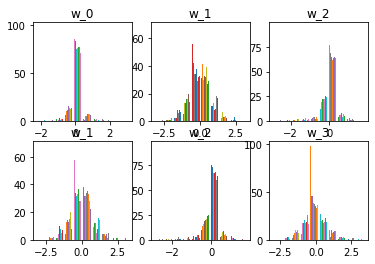

In [ ]:
fig, ax = plt.subplots(2, 3, sharey=False, tight_layout=False)
for i in range(2):
  for j in range(3):
    ax[i][j].hist(traced_w[i+j])
    ax[i][j].set_title("w_%i"%(i+j))

Comparing prior to posterior weights:

In [170]:
prior_w = []
for i in range(n_nodes):
  prior_w.append(mcmc.trace("w_%i"%i)[0])

posterior_w = []
for i in range(n_nodes):
  posterior_w.append(mcmc.trace("w_%i"%i)[n_iter-1-burn])  

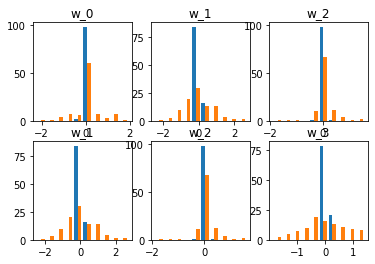

In [171]:
fig, ax = plt.subplots(2, 3, sharey=False, tight_layout=False)
for i in range(2):
  for j in range(3):
    ax[i][j].hist([prior_w[i+j], posterior_w[i+j]], label=["Prior", "Posterior"])
    ax[i][j].set_title("w_%i"%(i+j))

Comparing to a frequentist model:

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')
svc.fit(X_train, labels_train)
predictions = svc.predict(X=X_test)

print("Binary SVC accuracy: {}%".format(np.mean(predictions == labels_test)*100))

Binary SVC accuracy: 78.0%


**My multiclass example:**

Building the dataset:

In [ ]:
data_size = 400
x1_0, x2_0 = make_regression(n_samples = data_size, n_features=1, bias = 0.0, noise=12.3)                     #label 0
x1_1, x2_1 = make_regression(n_samples = data_size, n_features=1, bias = 5.0, noise=12.3)                     #label 1
x1_2, x2_2 = make_regression(n_samples = data_size, n_features=1, bias = 0.0, noise=12.3)                    #label 2
x1_3, x2_3 = make_regression(n_samples = data_size, n_features=1, bias = 5.0, noise=12.3)                    #label 2

x1_1 = 2*x1_1 + 7                                                                                   #changing the center position of the cluster of points
x2_1 = 2*x2_1 + 7

x1_2 = 2*x1_2 + 14                                                                                   #changing the center position of the cluster of points
x2_2 = 2*x2_2 + 14

x1_3 = 2*x1_3 + 20                                                                                   #changing the center position of the cluster of points
x2_3 = 2*x2_3 + 20

X_0 = np.concatenate((x1_0, x2_0.reshape(-1, 1)), axis=1)                                                     #shape = (100, 2)
X_1 = np.concatenate((x1_1, x2_1.reshape(-1, 1)), axis=1)                                                     #shape = (100, 2)
X_2 = np.concatenate((x1_2, x2_2.reshape(-1, 1)), axis=1)                                                     #shape = (100, 2)
X_3 = np.concatenate((x1_3, x2_3.reshape(-1, 1)), axis=1)                                                     #shape = (100, 2)

slice1 = int(data_size/4)

X_train = np.concatenate((X_0[:slice1][:], X_1[:slice1][:]), axis = 0)       
X_train = np.concatenate((X_train, X_2[:slice1][:]), axis = 0)      
X_train = np.concatenate((X_train, X_3[:slice1][:]), axis = 0)                                               #shape = (100, 2)
labels_train = np.concatenate((np.array([0. for i in range(slice1)]), np.array([1. for i in range(slice1)])), axis = None)
labels_train = np.concatenate((labels_train, np.array([2. for i in range(slice1)])), axis = None)
labels_train = np.concatenate((labels_train, np.array([3. for i in range(slice1)])), axis = None)
X_test = np.concatenate((X_0[slice1:][:], X_1[slice1:][:]), axis = 0)       
X_test = np.concatenate((X_test, X_2[slice1:][:]), axis = 0)      
X_test = np.concatenate((X_test, X_3[slice1:][:]), axis = 0)                                               #shape = (100, 2)
labels_test = np.concatenate((np.array([0. for i in range(slice1)]), np.array([1. for i in range(slice1)])), axis = None)
labels_test = np.concatenate((labels_test, np.array([2. for i in range(slice1)])), axis = None)
labels_test = np.concatenate((labels_test, np.array([3. for i in range(slice1)])), axis = None)


train = list(zip(X_train, labels_train))                                                       #shuffling data
test = list(zip(X_test, labels_test))

#Shuffling data
np.random.shuffle(train)
np.random.shuffle(test)

for i in range(data_size):
  X_train[i] = train[i][0]
  X_test[i] = test[i][0]
  labels_train[i] = train[i][1]
  labels_test[i] = test[i][1]

Plotting the generated data:

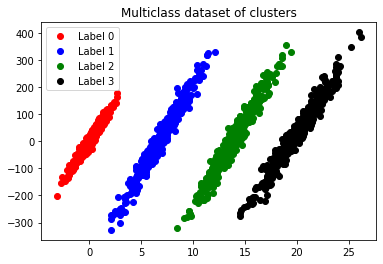

In [ ]:
plt.plot(x1_0, x2_0, 'ro')
plt.plot(x1_1, x2_1, 'bo')
plt.plot(x1_2, x2_2, 'o', color='green')
plt.plot(x1_3, x2_3, 'o', color='black')
plt.legend(["Label 0", "Label 1", "Label 2", "Label 3"])
plt.title("Multiclass dataset of clusters")
plt.show()

Building the network:

In [ ]:
n_nodes = 6
w = pm.Container([pm.Normal("w_%i"%j, 0, 1, value=np.random.randn(data_size)) for j in range(n_nodes)])

In [ ]:
@pm.deterministic
def NN3(X=X_train, w=w):
  node1 = np.tanh(w[0]*X[:, 0] + w[1]*X[:, 1])
  node2 = np.tanh(w[:][2]*X[:, 0] + w[:][3]*X[:, 1])
  x = w[4] * node1 + w[5] * node2
  node3 = np.exp(x) / np.sum(np.exp(x))
  node3_last = 1 - sum(node3[:-1])                                                     #must sum up to 1, not 0.999999
  node3[-1] = node3_last
  return node3

Building the model:

In [ ]:
n_iter = 10000
burn = 0

y = pm.Container("labels_train1", labels_train)

predictions = pm.Categorical("predictions", NN3, value=np.random.randn(data_size), observed=y)

model = pm.Model([predictions, w, y, NN])
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(iter=n_iter, burn=burn)

ZeroProbability: ignored

Tracing the predictions:

In [ ]:
def NN4(X=X_train, w=w):
  node1 = np.tanh(w[0]*X[:, 0] + w[1]*X[:, 1])
  node2 = np.tanh(w[:][2]*X[:, 0] + w[:][3]*X[:, 1])
  x = w[4] * node1 + w[5] * node2
  node3 = np.exp(x) / np.sum(np.exp(x))
  node3_last = 1 - sum(node3[:-1])                                                     #must sum up to 1, not 0.999999
  node3[-1] = node3_last
  return node3

In [ ]:
#Tracing the weights
new_w = []
for i in range(n_nodes):
  new_w.append(mcmc.trace("w_%i"%i)[n_iter-1-burn])
  
#Calculating the probabilities for the Bernoulli distributions of the predictions
train_pred_p = NN4(X_train, new_w)
test_pred_p = NN4(X_test, new_w)

#Obtaining the train and test predictions
test_pred = []
for i in range(len(test_pred_p)):
  test_pred.append(np.random.binomial(1, test_pred_p[i]))

train_pred = []
for i in range(len(train_pred_p)):
  train_pred.append(np.random.binomial(1, train_pred_p[i]))  


print("Accuracy of the binary model: {}%".format(sum(test_pred == labels_test)/data_size*100))

Tracing and plotting posteriors:

In [ ]:
traced_w = []
for i in range(n_nodes):
  traced_w.append([])
  for j in range(n_iter-1-burn):
    traced_w[i].append(mcmc.trace("w_%i"%i)[j])

In [ ]:
fig, ax = plt.subplots(2, 3, sharey=False, tight_layout=False)
for i in range(2):
  for j in range(3):
    ax[i][j].hist(traced_w[i+j])
    ax[i][j].set_title("w_%i"%(i+j))

Comparing prior to posterior weights:

In [ ]:
prior_w = []
for i in range(n_nodes):
  prior_w.append(mcmc.trace("w_%i"%i)[0])

posterior_w = []
for i in range(n_nodes):
  posterior_w.append(mcmc.trace("w_%i"%i)[n_iter-1-burn])  

In [ ]:
fig, ax = plt.subplots(2, 3, sharey=False, tight_layout=False)
for i in range(2):
  for j in range(3):
    ax[i][j].hist([prior_w[i+j], posterior_w[i+j]], label=["Prior", "Posterior"])
    ax[i][j].set_title("w_%i"%(i+j))

Comparing to a frequentist model:

In [ ]:
svc = SVC(kernel='rbf')

svc.fit(X_train, labels_train)
predictions = svc.predict(X=X_test)

accuracy = np.mean(np.array([predictions[i] == labels_test[i] for i in range(data_size)]))
print("Multiclass SVC accuracy: {}%".format(accuracy*100))

Multiclass SVC accuracy: 23.5%
